# Demo for octDPSNet

In [1]:
# show pointclouds
import open3d as o3d

In [2]:
from models.octDPSNet import octdpsnet
import numpy as np

import torch
import torch.backends.cudnn as cudnn
from models import octconv

import cv2

In [3]:
############################
# select data
############################
test_folder = './sample_data/sun3d_test_00047/'
# test_folder = './sample_data/mvs_test_00023/'
# test_folder = './sample_data/rgbd_test_00038/'

In [4]:
nlabel = 64
mindepth = 0.5
octconv.ALPHA = 0.75
mymodel = octdpsnet(nlabel, mindepth, octconv.ALPHA, True).cuda()
mymodel.eval()
print('Load:')

octDPSNet
octconv alpha: 0.75
octdps_a75n64-2c47a5f9.pth
Load:


In [5]:
import matplotlib.pyplot as plt
def ToImg(img):
    return img.cpu().numpy().transpose(1,2,0)/2 + 0.5

def showImg(img):
    ret = ToImg(img)
    plt.imshow(ret)
    
def imread(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def ToT(img):
    img = torch.from_numpy(img.transpose(2, 0, 1)).float()/255
    return (img-0.5)*2

def preprocess(tgt_img, imgs, ref_poses, intrinsics):
    tgt_img = ToT(tgt_img)[np.newaxis]
    imgs = [ToT(it)[np.newaxis] for it in imgs]
    ref_poses = [torch.from_numpy(it)[np.newaxis].float() for it in ref_poses]
    inv_intrinsic = np.linalg.inv(intrinsics)
    intrinsics = torch.from_numpy(intrinsics).float()
    inv_intrinsic = torch.from_numpy(inv_intrinsic).float()
    return tgt_img, imgs, ref_poses, intrinsics, inv_intrinsic



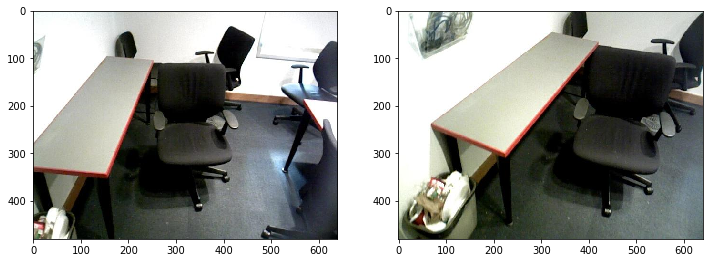

In [6]:
from functools import partial

fname_l = test_folder + '/0000.jpg'
fname_r = test_folder + '/0001.jpg'
tgt_img = imread(fname_l)
img = imread(fname_r)

# intrinsics = np.array([[386.8946, 0, 382.7535],
#                        [0, 386.8946, 219.6522],
#                        [0, 0, 1]])
# ref_poses = [np.array([[[0.9360, 0.0590, 0.3470, -566.4332],
#                      [-0.0623, 0.9981, -0.0019, 17.1064],
#                      [-0.3464, -0.0198, 0.9379,  123.5660]]])]

intrinsics = np.loadtxt(test_folder + '/cam.txt')

poses = np.loadtxt(test_folder + '/poses.txt')
pose_tgt = np.concatenate((poses[0,:].reshape((3,4)), np.array([[0,0,0,1]])), axis=0)
for j in [1]:
    pose_src = np.concatenate((poses[j,:].reshape((3,4)), np.array([[0,0,0,1]])), axis=0)
    pose_rel = pose_src.dot(np.linalg.inv(pose_tgt))
    pose = pose_rel[:3,:].reshape((1,3,4)).astype(np.float32)
ref_poses = [pose]

# visualize
fig, ax  = plt.subplots(1, 2, figsize=(12,9))
ax = ax.flatten()

ax[0].imshow(tgt_img)
ax[1].imshow(img)


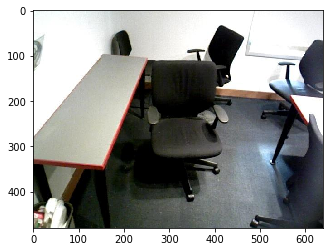

In [7]:
# preprocess image
resize_x = 640
resize_y = 480
h, w, c = tgt_img.shape
x_scale = resize_x/w
y_scale = resize_y/h
intrinsics[0] *= x_scale
intrinsics[1] *= y_scale

tgt_img = cv2.resize(tgt_img, (resize_x, resize_y))
img = cv2.resize(img, (resize_x, resize_y))

imgs = [img]  # imgs = [img1, img2]
ref_poses = [pose]  # imgs = [pose1, pose2]

org_img = np.array(tgt_img, dtype=np.uint8)

tgt_img, imgs, ref_poses, intrinsics, inv_intrinsic = preprocess(tgt_img, imgs, ref_poses, intrinsics)

showImg(tgt_img[0])

In [8]:
ref_poses

[tensor([[[[ 0.9290, -0.1894,  0.3179, -0.2369],
           [ 0.2086,  0.9776, -0.0273,  0.0216],
           [-0.3056,  0.0917,  0.9477, -0.1325]]]])]

depth max: 3.2884035
depth min: 1.2159722


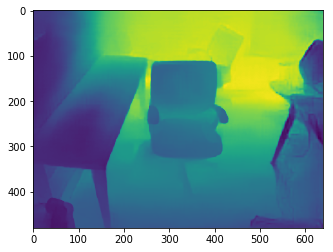

In [9]:
with torch.no_grad():
    tgt_img = tgt_img.cuda()
    imgs = [it.cuda() for it in imgs]
    ref_poses = [it.cuda() for it in ref_poses]
    intrinsics = intrinsics[np.newaxis].cuda()
    inv_intrinsic = inv_intrinsic[np.newaxis].cuda()
    ref_poses = torch.cat(ref_poses,1)
    output_depth = mymodel(tgt_img, imgs, ref_poses, intrinsics, inv_intrinsic)    
    depth = output_depth.squeeze().cpu().numpy()
    
print('depth max:', depth.max())
print('depth min:', depth.min())
plt.imshow(depth)

# Show PointCloud

In [10]:
def pcdCamera(scale=1.0, color=[1, 0, 0]):
    points = [[-1, 0.75, 0],[1, 0.75, 0],[1, -0.75, 0],[-1, -0.75, 0],[0,0,0.6]]
    lines = [[0,1],[1,2],[2,3],[3,0],
             [0,4],[1,4],[2,4],[3,4]]
    colors = [color for i in range(len(lines))]
    line_set = o3d.geometry.LineSet()

    points = np.array(points)*scale
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    return line_set

In [11]:
img = org_img
resize_x = 640
resize_y = 480
img = cv2.resize(img, (resize_x, resize_y))

height, width, _ = img.shape
cam = intrinsics.cpu().numpy()[0]
fx = cam[0,0]
fy = cam[1,1]
cx = cam[0,2]
cy = cam[1,2]
cam_o3 = o3d.camera.PinholeCameraIntrinsic(width, height, fx,fy,cx,cy)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(img), o3d.geometry.Image(depth), 
    depth_scale=1.0, depth_trunc=100, convert_rgb_to_intensity=False)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam_o3)

colors = [[i==0, i==1, i==2] for i in range(3)]
d = depth
camera_scale = d[d>0.01].min()/9
cam_ext = ref_poses.cpu().numpy()[0]
cam_pcds = []
cam_pcd = pcdCamera(-camera_scale, colors[0])
cam_pcds.append(cam_pcd)

for i, it in enumerate(cam_ext):
    cam_pcd = pcdCamera(-camera_scale, colors[i+1])
    T = np.concatenate((it, np.array([[0,0,0,1]])), axis=0)
    invT = np.linalg.inv(T)
    cam_pcd.transform(invT)
    cam_pcds.append(cam_pcd)

show_pcds = [pcd, *cam_pcds]
for it in show_pcds:
    it.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries(show_pcds)

In [12]:
# o3d.io.write_point_cloud('results.ply', pcd)